## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import calib_utils
from utils import post_utils
from utils import config_utils
from utils import eval_utils
from utils import model_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [23]:
iso_code = "SEN"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AS.yaml")
config_file = os.path.join(os.getcwd(), "configs/best_models.yaml")
data_config = config_utils.load_config(data_config_file)
config = config_utils.create_config(config_file)

## Load Validation Results

In [3]:
val_output = model_utils.ensemble_models(iso_code, config, phase="val")
test_output = model_utils.ensemble_models(iso_code, config, phase="test")
print(test_output.shape)
test_output.head(3)

(1888, 18)


,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-SEN-SCHOOL-00000075,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole d'Elinkine,NaN,0,0.0,school,13,rural,test,POINT (-1645442.8880473897 1541725.5277999148),1,1,0.953690
1,OSM-SEN-SCHOOL-00000161,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole 1,NaN,0,0.0,school,23,urban,test,POINT (-1319954.9528390914 1954650.5035527328),1,1,0.960500
2,OSM-SEN-SCHOOL-00000185,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole Elémentaire Tivaouane 13,NaN,0,0.0,school,30,urban,test,POINT (-1648856.406144037 1841900.0392739468),1,1,0.941142


## Load Evaluation

In [7]:
val_results = eval_utils.evaluate(
    y_true=val_output["y_true"], 
    y_pred=val_output["y_preds"], 
    y_prob=val_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2
)
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results

{'auprc': 0.992815755669581,
 'ap': 0.992815755669581,
 'roc_auc': 0.9964063837005008,
 'brier_score': 0.022762337466030794,
 'precision_scores_': array([0.3315678 , 0.33174351, 0.33191941, ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.        , 1.        , 1.        , ..., 0.00319489, 0.00159744,
        0.        ]),
 'pr_thresholds': array([0.02945072, 0.03391726, 0.03464859, ..., 0.96264513, 0.96287423,
        0.96826184]),
 'det_thresholds': array([0.04709869, 0.04716974, 0.04717159, ..., 0.95181394, 0.95183732,
        0.95187187]),
 'fpr': array([0.76862124, 0.76862124, 0.76782884, ..., 0.00079239, 0.00079239,
        0.        ]),
 'fnr': array([0.        , 0.00159744, 0.00159744, ..., 0.71884984, 0.72044728,
        0.72044728]),
 'optim_threshold': 0.35514597967267036,
 'fbeta_score': 98.48484848484847,
 'precision_score': 93.97590361445783,
 'recall_score': 99.68051118210862,
 'overall_accuracy': 97.77542372881356,
 'balanced_accuracy': 98.2

## Generate results at probability threshold=0.5

In [8]:
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=1,
    optim_threshold=0.5
)
test_results

{'auprc': 0.992815755669581,
 'ap': 0.992815755669581,
 'roc_auc': 0.9964063837005008,
 'brier_score': 0.022762337466030794,
 'precision_scores_': array([0.3315678 , 0.33174351, 0.33191941, ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.        , 1.        , 1.        , ..., 0.00319489, 0.00159744,
        0.        ]),
 'pr_thresholds': array([0.02945072, 0.03391726, 0.03464859, ..., 0.96264513, 0.96287423,
        0.96826184]),
 'det_thresholds': array([0.04709869, 0.04716974, 0.04717159, ..., 0.95181394, 0.95183732,
        0.95187187]),
 'fpr': array([0.76862124, 0.76862124, 0.76782884, ..., 0.00079239, 0.00079239,
        0.        ]),
 'fnr': array([0.        , 0.00159744, 0.00159744, ..., 0.71884984, 0.72044728,
        0.72044728]),
 'optim_threshold': 0.5,
 'fbeta_score': 97.86223277909738,
 'precision_score': 97.01726844583987,
 'recall_score': 98.7220447284345,
 'overall_accuracy': 98.56991525423729,
 'balanced_accuracy': 98.60824898862295}

In [9]:
preds = [int(x) for x in list(test_output['y_probs'] > 0.5)]
cm, cm_metrics, cm_report = eval_utils.get_confusion_matrix(
    test_output['y_true'], preds, [1, 0]
)
print(cm_metrics)
cm

   precision     recall   f1_score
1  97.017268  98.722045  97.862233
0  99.360512  98.494453  98.925587


,1,0
1,618,8
0,19,1243


### Per-country Regional Model Results

In [ ]:
test_output_sub = test_output[test_output["iso"] == "ZWE"]
test_results = eval_utils.evaluate(
    y_true=test_output_sub["y_true"], 
    y_pred=test_output_sub["y_preds"], 
    y_prob=test_output_sub["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results

## Plot Results

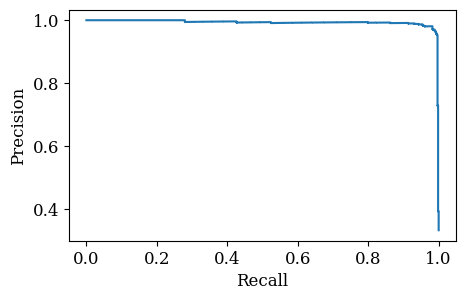

In [10]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

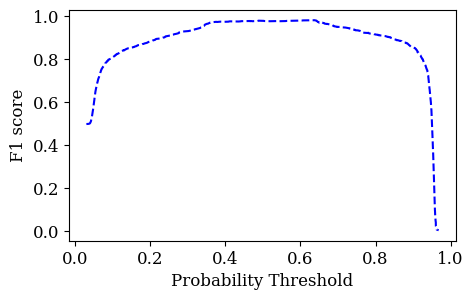

In [12]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['pr_thresholds'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['pr_thresholds'], test_fscores[:-1], "b--");
ax.set_ylabel("F1 score")
ax.set_xlabel("Probability Threshold");

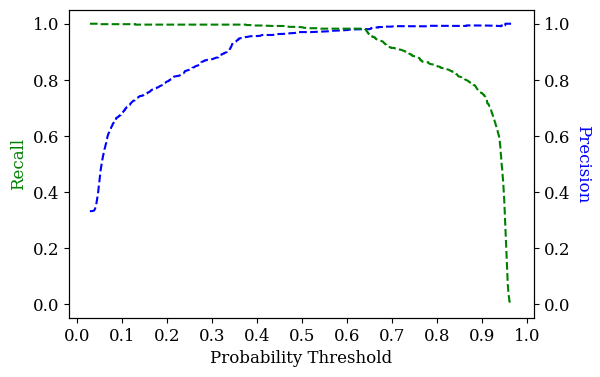

In [24]:
eval_utils.plot_results(test_results, plot="pr")

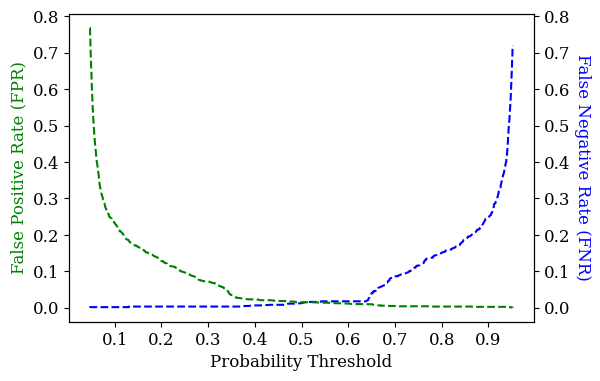

In [25]:
eval_utils.plot_results(test_results, plot="det")